In [1]:
from optyx.path import *
from optyx.circuit import Phase
from sympy.abc import theta, phi

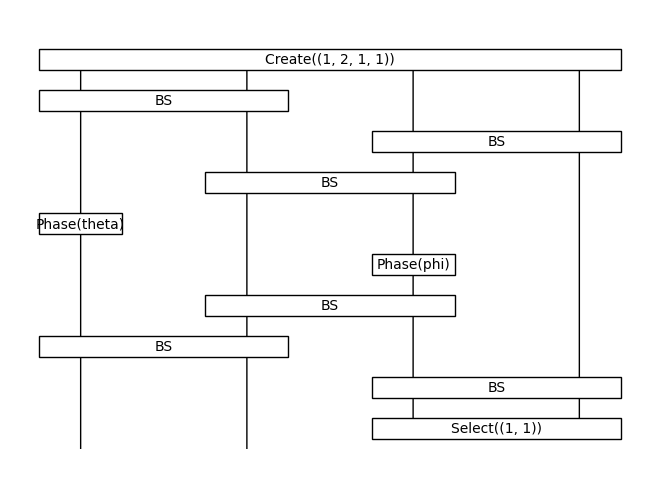

In [2]:
circuit = Create(1, 2, 1, 1) >> BS @ BS >> Id(1) @ BS @ Id(1) >> Phase(theta) @ Id(1) @ Phase(phi) @ Id(1) >> Id(1) @ BS @ Id(1)  >> BS @ BS >> Id(2) @ Select(1, 1) 
circuit.draw()

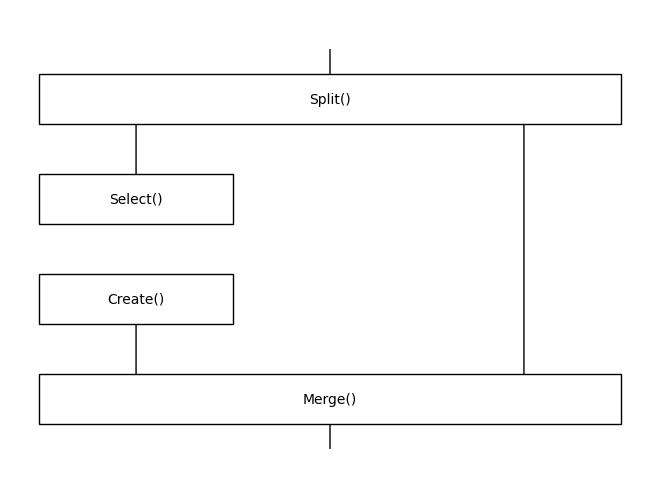

In [3]:
annil = Split() >> (Select() @ Id(1))
create = (Create() @ Id(1)) >> Merge()
num_op = Split() >> (Select() >> Create()) @ Id(1) >> Merge()
num_op.draw()

In [4]:
# Bose-Hubbard hamitonian
strength = 25
chemical_potential = 14
hopping = create @ annil + annil @ create
site_repulsion = num_op >> num_op + Scalar(-1) @ num_op
repulsion = site_repulsion @ Id(1) + Id(1) @ site_repulsion

bose_hubbard = Scalar(-1) @ hopping + Scalar(strength / 2) @ repulsion + Scalar(-chemical_potential) @ (num_op @ Id(1) + Id(1) @ num_op)

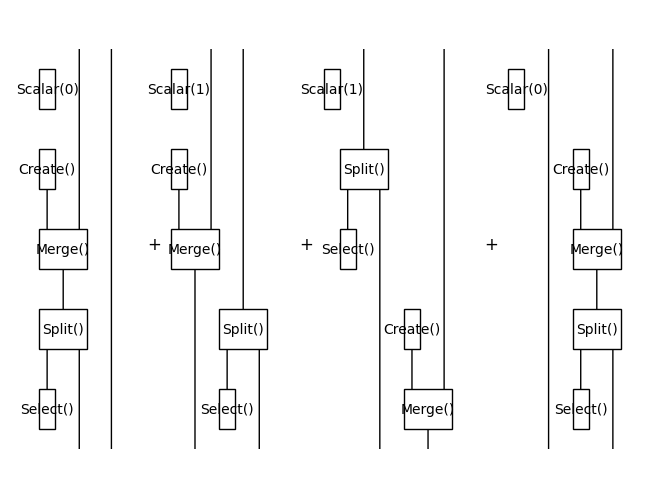

In [6]:
# Linear bosonic hamiltonians

H = [[0, 1], [1, 0]] # Hermitian matrix

hamiltonian = Scalar(H[0][0]) @ (create >> annil) @ Id(1) + Scalar(H[0][1]) @ create @ annil + Scalar(H[1][0]) @ annil @ create + Scalar(H[1][1]) @ Id(1) @ (create >> annil)
hamiltonian.draw()

In [7]:
expectation = circuit >> hamiltonian >> circuit.dagger()

In [8]:
def to_float(x):
    if isinstance(x, complex):
        assert x.imag < 1e-10
        return x.real
    return x

free_syms = expectation.free_symbols

f_exp = lambda xs: to_float(expectation.lambdify(*free_syms)(*xs).eval().array[0, 0])

def d_f_exp(xs):
    return [
        expectation.grad(s).lambdify(*free_syms)(*xs).eval().array[0, 0]
        for s in free_syms
    ]

In [12]:
from tqdm import tqdm

xs = []
fxs = []
dfxs = []

def optimize(x0):
    x = x0

    for _ in tqdm(range(20)):
        fx = f_exp(x)
        dfx = d_f_exp(x)
        
        xs.append(x[::])
        fxs.append(fx)
        dfxs.append(dfx)
        for i, dfxx in enumerate(dfx):
            x[i] = to_float(x[i] - 0.01 * dfxx)
    xs.append(x[::])
    fxs.append(f_exp(x))
    dfxs.append(d_f_exp(x))

In [13]:
optimize([0.4, 0.9])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


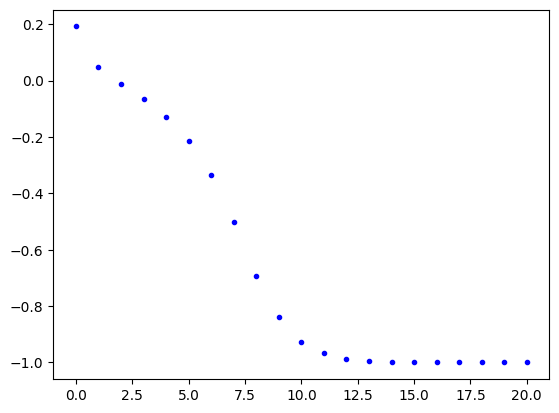

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(len(xs)),fxs,'b.')
plt.show()